Здесь тот файл, что mdlj выдает будем приводить к моей csv-шке
---

In [1]:
import random
import os
import time

from numba import jit, njit, vectorize
import numpy as np
import scipy
from numpy.linalg import norm as norm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from tqdm import tqdm
import gc

from itertools import islice
from collections import defaultdict
import csv

In [2]:
!rm *.csv *.xyz

In [1]:
!./md -N 2 -ns 10000 -outf 1 -thermof 1000 -dt 0.0001 -T0 0.1

# NVE MD Simulation of a Lennard - Jones fluid
# L = 2.5198421 rho = 0.125 N = 2 r_cut = 1000000
# Steps number = 10000 seed = 1676805192 dt = 0.0001
# step time PE KE TE drift T
0 0 -0.75 0.3 -0.45 0 0.1
1000 0.1 -0.91700184 0.46687748 -0.45012437 0.00027636674 0.15562583
2000 0.2 -0.96238186 0.51225744 -0.45012442 0.00027648726 0.17075248
3000 0.3 -0.83144094 0.38131659 -0.45012435 0.000276324 0.12710553
4000 0.4 -0.98486833 0.53474394 -0.45012439 0.00027641668 0.17824798
5000 0.5 -0.81095758 0.36083322 -0.45012436 0.00027634474 0.12027774
6000 0.6 -0.6946448 0.24452045 -0.45012435 0.00027634295 0.081506816
7000 0.7 -0.67242082 0.22229647 -0.45012435 0.00027634371 0.074098822
8000 0.8 -0.74021636 0.29009201 -0.45012435 0.00027634223 0.096697337
9000 0.9 -0.90157627 0.45145191 -0.45012436 0.00027636118 0.15048397
10000 1 -0.97876676 0.52864234 -0.45012442 0.00027648951 0.17621411
2.5198421


In [4]:
N = 2
L = 2 * N ** (1 / 3)
L

2.5198420997897464

In [5]:
read_path = f'N{N}.xyz'

In [6]:
# NUMPY VERSION:

def csv_from_xyz(read_path=read_path, use_particles=None, step=1, lines_read_coef=None, velocity_regime=None):
    '''
    создает .csv формат из .vel
    по-сути делает цсв-хи с которыми я работаю из LAMMPS-овского аутпута

    use_particles - количество частиц, которое использовать, то есть сколько из записанных координат использовать (это нормально реализовать супер геморрой)
    recalculate_vels - пересчитать силы
    normalize_vels - нормализовать силы

    step - шаг на количество позиций при чтении (оно в текущей версии очень долго работает с этим параметром)
    lines_read_coef - N * lines_read_coef строчек с координатами считывается - то есть lines_read_coed - количество конфигураций, которое считывается
    '''
    # через решейп к (lines_read, 3) - удаляем с шагом строчки: x = np.delete(x, np.arange(0, x.size, use_particles))

    with open(read_path, 'r+') as read_f:
        all_vels = []
        all_coords = []
        lines_read = 0  # строчки с координатами прочитанные
        for line in (read_f):
            if line[0] != 'L' and len(line) > 2:
                # if lines_read in actual_steps:
                    # if lines_read % (N * step) == 0:    # делаем шаг
                    arr = list(map(lambda x: float(x.strip()), line.split(' ')))
                    arr_coords = (arr[:3])
                    arr_vels = (arr[3:])
                    all_vels.extend(arr_vels)
                    all_coords.extend(arr_coords)
                    lines_read += 1

            if lines_read_coef and lines_read >= lines_read_coef * N:
                break
    all_coords = np.reshape(all_coords, (lines_read // N, 3 * N))
    all_vels = np.reshape(all_vels, (lines_read // N, 3 * N))

    # CFG.N = N
    coords_path = 'coords' + str(N) + '.csv'
    velocities_path = 'velocities' + str(N) + '.csv'

    fieldnames_vels = []
    fieldnames_coords = []
    for i in range(N):
        fieldnames_coords.extend([str(i) + 'x', str(i) + 'y', str(i) + 'z'])

        fieldnames_vels.extend([str(i) + "v_x", str(i) + "v_y", str(i) + "v_z"])

    if not velocity_regime:
        df_coords = pd.DataFrame(all_coords,
                    index=np.arange(len(all_coords)),
                    columns=fieldnames_coords)[int(0.5 * len(all_coords)):]     # на старте там паника какая-то происходит - откидываем стартовые точки
        df_coords.index.name = 't'
        df_coords.to_csv(coords_path)

    df_vels = pd.DataFrame(all_vels,
                index=np.arange(len(all_vels)),
                columns=fieldnames_vels).iloc[int(0.5 * len(all_vels)):]
    df_vels.index.name = 't'
    df_vels.to_csv(velocities_path)

In [7]:
csv_from_xyz()

In [8]:
@njit
def pot_energy(r1, r2):
    # Snaps particle back to the unfolded coordinate
    r1 = r1 % L
    r2 = r2 % L
    r = r1 - r2
    for i in range(3):
        if np.abs(r[i]) > L / 2:   # Если расстояние между двумя частицами больше L/2, то мы точно найдем в соседних клетках ближе
            r[i] = r[i] - L * np.sign(r[i])

    d = norm(r)
    return -4 * (pow(d, -6) - pow(d, -12))

def plot_energy(N=N, path_coords=f"coords{N}.csv", path_vels=f"velocities{N}.csv"):
    E = []
    try:
        coords = pd.read_csv(path_coords).drop(columns=["t"])
        vels = pd.read_csv(path_vels).drop(columns=["t"])
    except:
        coords = pd.read_csv(path_coords)
        vels = pd.read_csv(path_vels)
    
    for row_n in tqdm(range(len(vels))):  # TODO: ЗДЕСЬ СТОИТ vels ПОТОМУ ЧТО У МЕНЯ ПОКА БАГА И В КООРДС НА ОДНУ СТРОЧКУ БОЛЬШЕ ПОЧЕМУ-ТО...
        V = 0
        T = 0
        for i in range(N):
            r_i = np.array(coords.iloc[row_n, (3 * i):(3 * i) + 3])

            for j in range(i + 1, N):
                r_j = np.array(coords.iloc[row_n, (3 * j):(3 * j) + 3])
                # print(r_i, r_j)
                V += pot_energy(r_i, r_j)
        

        T = ((vels.iloc[row_n]) ** 2).sum() / 2
        E.append(T + V)

        # print(
        #     f'{row_n}: K = {T}, V = {V}, E = {T + V}'
        # )

    plt.figure(figsize=(10, 10))
    plt.plot(
        [i for i in range(len(E))], E
    )

    avg_E = np.array(E).mean()

    # print(E)

    plt.ylim([-0.1 + avg_E, 0.1 + avg_E])
    # plt.xlabel()

100%|██████████| 5001/5001 [00:02<00:00, 1733.96it/s]


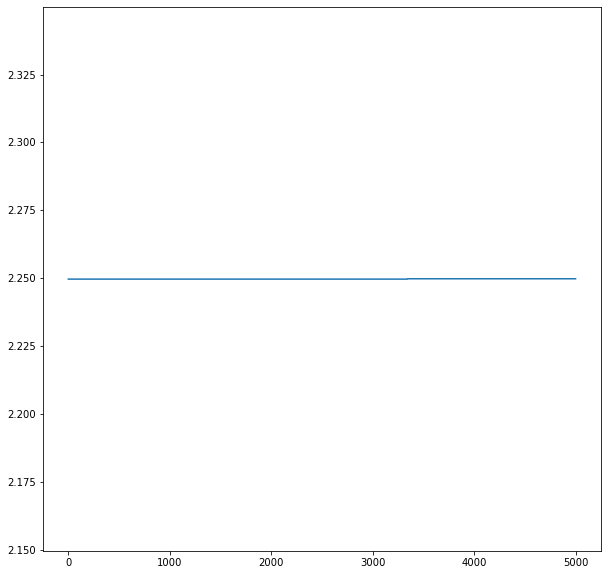

In [9]:
plot_energy()